In [1]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px

In [2]:
data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)



In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [4]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1.Define Encoder and Decoder classes

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        #self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss

In [8]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

## 3.Training

In [9]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [10]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [11]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 69299.546875
	 partial train loss (single batch): 67905.148438
	 partial train loss (single batch): 66163.218750
	 partial train loss (single batch): 64483.656250
	 partial train loss (single batch): 62773.468750
	 partial train loss (single batch): 62332.816406
	 partial train loss (single batch): 61332.429688
	 partial train loss (single batch): 60605.242188
	 partial train loss (single batch): 60176.910156
	 partial train loss (single batch): 59266.429688
	 partial train loss (single batch): 58928.289062
	 partial train loss (single batch): 58262.863281
	 partial train loss (single batch): 57640.652344
	 partial train loss (single batch): 57360.722656
	 partial train loss (single batch): 56498.347656
	 partial train loss (single batch): 56237.273438
	 partial train loss (single batch): 55639.281250
	 partial train loss (single batch): 55475.332031
	 partial train loss (single batch): 55028.390625
	 partial train loss (single batch): 54763.644531


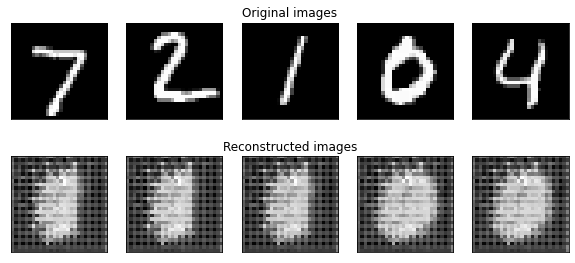

	 partial train loss (single batch): 19865.869141
	 partial train loss (single batch): 19527.164062
	 partial train loss (single batch): 19752.195312
	 partial train loss (single batch): 19626.023438
	 partial train loss (single batch): 19817.814453
	 partial train loss (single batch): 19435.447266
	 partial train loss (single batch): 19465.742188
	 partial train loss (single batch): 19181.996094
	 partial train loss (single batch): 19203.605469
	 partial train loss (single batch): 19146.941406
	 partial train loss (single batch): 19135.759766
	 partial train loss (single batch): 19104.433594
	 partial train loss (single batch): 18954.105469
	 partial train loss (single batch): 18933.851562
	 partial train loss (single batch): 19081.583984
	 partial train loss (single batch): 18821.396484
	 partial train loss (single batch): 19009.519531
	 partial train loss (single batch): 18710.359375
	 partial train loss (single batch): 18738.572266
	 partial train loss (single batch): 18755.093750


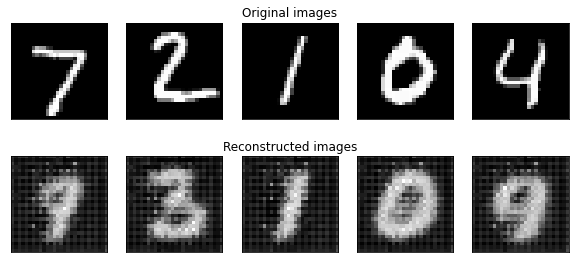

	 partial train loss (single batch): 13240.147461
	 partial train loss (single batch): 12995.378906
	 partial train loss (single batch): 13427.228516
	 partial train loss (single batch): 13287.852539
	 partial train loss (single batch): 13844.486328
	 partial train loss (single batch): 13077.857422
	 partial train loss (single batch): 13245.648438
	 partial train loss (single batch): 13060.951172
	 partial train loss (single batch): 12794.210938
	 partial train loss (single batch): 13062.657227
	 partial train loss (single batch): 12866.151367
	 partial train loss (single batch): 13003.693359
	 partial train loss (single batch): 12860.583984
	 partial train loss (single batch): 12985.680664
	 partial train loss (single batch): 13511.457031
	 partial train loss (single batch): 12948.303711
	 partial train loss (single batch): 13252.033203
	 partial train loss (single batch): 12918.420898
	 partial train loss (single batch): 12992.455078
	 partial train loss (single batch): 13224.232422


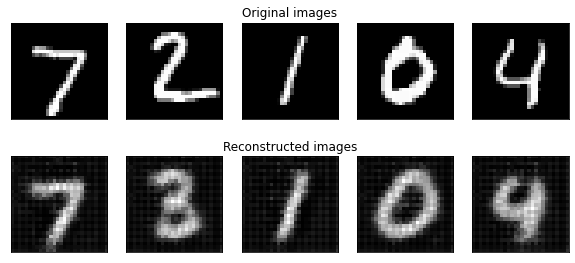

	 partial train loss (single batch): 10911.754883
	 partial train loss (single batch): 10692.574219
	 partial train loss (single batch): 11084.201172
	 partial train loss (single batch): 10973.644531
	 partial train loss (single batch): 11336.583984
	 partial train loss (single batch): 10780.224609
	 partial train loss (single batch): 11032.519531
	 partial train loss (single batch): 10862.854492
	 partial train loss (single batch): 10456.609375
	 partial train loss (single batch): 10856.391602
	 partial train loss (single batch): 10671.796875
	 partial train loss (single batch): 10669.555664
	 partial train loss (single batch): 10573.304688
	 partial train loss (single batch): 10833.081055
	 partial train loss (single batch): 11292.741211
	 partial train loss (single batch): 10712.848633
	 partial train loss (single batch): 11000.622070
	 partial train loss (single batch): 10677.333984
	 partial train loss (single batch): 10716.156250
	 partial train loss (single batch): 11066.824219


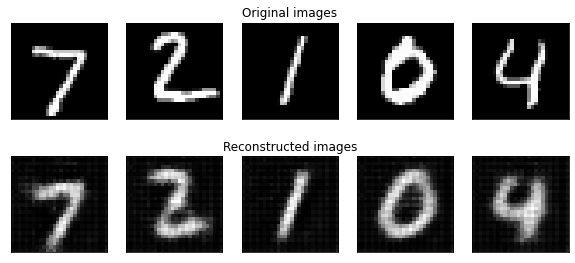

	 partial train loss (single batch): 10064.854492
	 partial train loss (single batch): 9771.493164
	 partial train loss (single batch): 10157.708984
	 partial train loss (single batch): 10035.507812
	 partial train loss (single batch): 10445.269531
	 partial train loss (single batch): 9849.216797
	 partial train loss (single batch): 10136.650391
	 partial train loss (single batch): 10049.180664
	 partial train loss (single batch): 9570.661133
	 partial train loss (single batch): 9973.854492
	 partial train loss (single batch): 9724.242188
	 partial train loss (single batch): 9825.386719
	 partial train loss (single batch): 9625.601562
	 partial train loss (single batch): 9970.149414
	 partial train loss (single batch): 10381.700195
	 partial train loss (single batch): 9838.050781
	 partial train loss (single batch): 10142.588867
	 partial train loss (single batch): 9864.187500
	 partial train loss (single batch): 9914.871094
	 partial train loss (single batch): 10343.189453
	 partial t

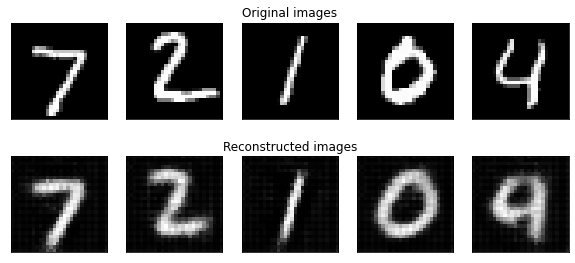

	 partial train loss (single batch): 9586.438477
	 partial train loss (single batch): 9422.141602
	 partial train loss (single batch): 9755.069336
	 partial train loss (single batch): 9739.289062
	 partial train loss (single batch): 9969.089844
	 partial train loss (single batch): 9434.758789
	 partial train loss (single batch): 9726.791992
	 partial train loss (single batch): 9688.806641
	 partial train loss (single batch): 9202.251953
	 partial train loss (single batch): 9586.232422
	 partial train loss (single batch): 9309.452148
	 partial train loss (single batch): 9462.839844
	 partial train loss (single batch): 9240.673828
	 partial train loss (single batch): 9667.658203
	 partial train loss (single batch): 9923.871094
	 partial train loss (single batch): 9499.311523
	 partial train loss (single batch): 9732.163086
	 partial train loss (single batch): 9465.868164
	 partial train loss (single batch): 9492.651367
	 partial train loss (single batch): 10018.346680
	 partial train los

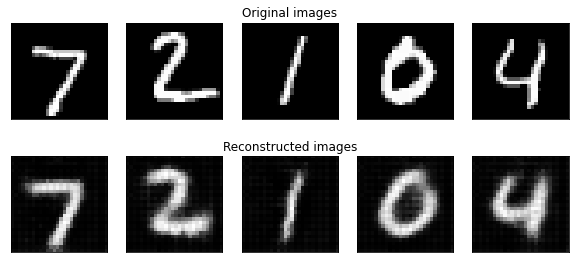

	 partial train loss (single batch): 9299.268555
	 partial train loss (single batch): 9174.064453
	 partial train loss (single batch): 9546.472656
	 partial train loss (single batch): 9535.263672
	 partial train loss (single batch): 9767.679688
	 partial train loss (single batch): 9279.382812
	 partial train loss (single batch): 9561.863281
	 partial train loss (single batch): 9500.564453
	 partial train loss (single batch): 8871.934570
	 partial train loss (single batch): 9355.471680
	 partial train loss (single batch): 9041.473633
	 partial train loss (single batch): 9241.765625
	 partial train loss (single batch): 9014.488281
	 partial train loss (single batch): 9366.824219
	 partial train loss (single batch): 9682.708984
	 partial train loss (single batch): 9265.225586
	 partial train loss (single batch): 9557.533203
	 partial train loss (single batch): 9208.250000
	 partial train loss (single batch): 9185.918945
	 partial train loss (single batch): 9817.475586
	 partial train loss

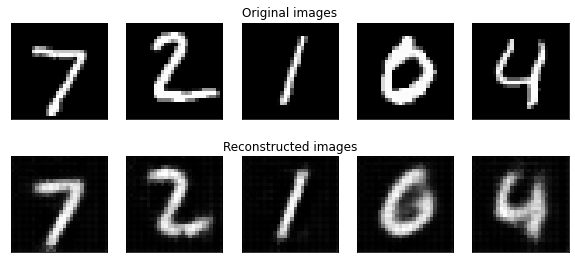

	 partial train loss (single batch): 9183.640625
	 partial train loss (single batch): 9057.465820
	 partial train loss (single batch): 9392.620117
	 partial train loss (single batch): 9291.839844
	 partial train loss (single batch): 9556.001953
	 partial train loss (single batch): 9069.667969
	 partial train loss (single batch): 9298.630859
	 partial train loss (single batch): 9326.806641
	 partial train loss (single batch): 8716.172852
	 partial train loss (single batch): 9207.082031
	 partial train loss (single batch): 8845.673828
	 partial train loss (single batch): 8996.736328
	 partial train loss (single batch): 8906.372070
	 partial train loss (single batch): 9269.995117
	 partial train loss (single batch): 9535.942383
	 partial train loss (single batch): 9128.879883
	 partial train loss (single batch): 9429.154297
	 partial train loss (single batch): 9088.820312
	 partial train loss (single batch): 8982.375000
	 partial train loss (single batch): 9685.951172
	 partial train loss

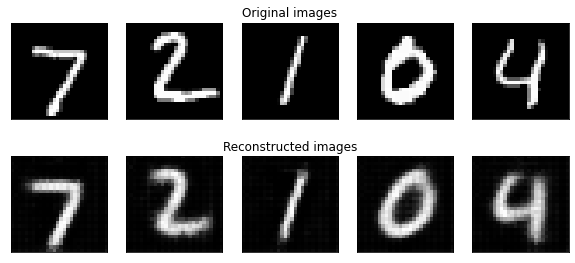

	 partial train loss (single batch): 9024.105469
	 partial train loss (single batch): 8893.319336
	 partial train loss (single batch): 9296.474609
	 partial train loss (single batch): 9252.491211
	 partial train loss (single batch): 9426.970703
	 partial train loss (single batch): 8924.400391
	 partial train loss (single batch): 9257.871094
	 partial train loss (single batch): 9235.718750
	 partial train loss (single batch): 8677.675781
	 partial train loss (single batch): 9189.082031
	 partial train loss (single batch): 8746.191406
	 partial train loss (single batch): 8951.846680
	 partial train loss (single batch): 8742.572266
	 partial train loss (single batch): 9071.290039
	 partial train loss (single batch): 9408.687500
	 partial train loss (single batch): 9032.522461
	 partial train loss (single batch): 9265.166992
	 partial train loss (single batch): 9006.470703
	 partial train loss (single batch): 8864.542969
	 partial train loss (single batch): 9420.066406
	 partial train loss

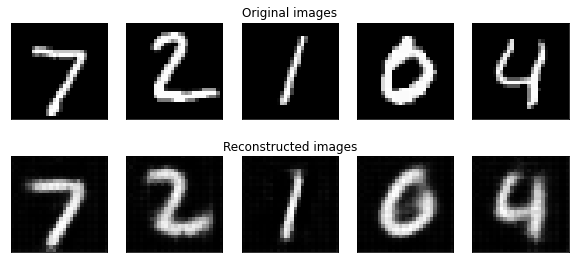

	 partial train loss (single batch): 8995.400391
	 partial train loss (single batch): 8791.570312
	 partial train loss (single batch): 9088.526367
	 partial train loss (single batch): 9007.876953
	 partial train loss (single batch): 9184.838867
	 partial train loss (single batch): 8874.929688
	 partial train loss (single batch): 9140.230469
	 partial train loss (single batch): 9155.847656
	 partial train loss (single batch): 8593.452148
	 partial train loss (single batch): 9076.344727
	 partial train loss (single batch): 8666.847656
	 partial train loss (single batch): 8851.749023
	 partial train loss (single batch): 8723.010742
	 partial train loss (single batch): 9057.833984
	 partial train loss (single batch): 9322.560547
	 partial train loss (single batch): 8909.201172
	 partial train loss (single batch): 9083.488281
	 partial train loss (single batch): 8873.518555
	 partial train loss (single batch): 8757.062500
	 partial train loss (single batch): 9384.227539
	 partial train loss

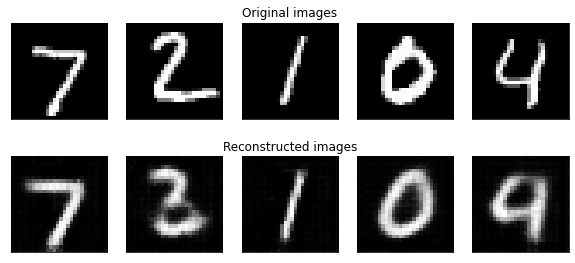

	 partial train loss (single batch): 8833.449219
	 partial train loss (single batch): 8707.651367
	 partial train loss (single batch): 9071.841797
	 partial train loss (single batch): 8970.323242
	 partial train loss (single batch): 9219.679688
	 partial train loss (single batch): 8743.701172
	 partial train loss (single batch): 9104.592773
	 partial train loss (single batch): 9064.574219
	 partial train loss (single batch): 8527.012695
	 partial train loss (single batch): 8981.363281
	 partial train loss (single batch): 8540.033203
	 partial train loss (single batch): 8757.932617
	 partial train loss (single batch): 8640.375000
	 partial train loss (single batch): 8974.525391
	 partial train loss (single batch): 9295.041016
	 partial train loss (single batch): 8756.479492
	 partial train loss (single batch): 9068.320312
	 partial train loss (single batch): 8741.079102
	 partial train loss (single batch): 8755.023438
	 partial train loss (single batch): 9330.990234
	 partial train loss

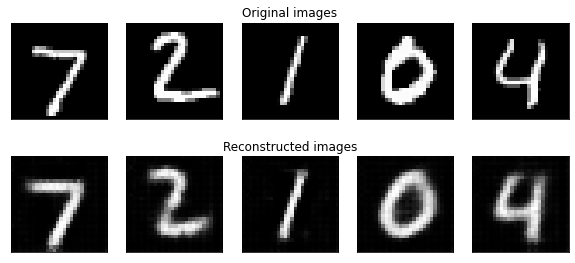

	 partial train loss (single batch): 8870.017578
	 partial train loss (single batch): 8720.432617
	 partial train loss (single batch): 8886.316406
	 partial train loss (single batch): 8947.840820
	 partial train loss (single batch): 9090.499023
	 partial train loss (single batch): 8741.634766
	 partial train loss (single batch): 8884.075195
	 partial train loss (single batch): 9077.548828
	 partial train loss (single batch): 8499.143555
	 partial train loss (single batch): 8873.089844
	 partial train loss (single batch): 8537.808594
	 partial train loss (single batch): 8784.267578
	 partial train loss (single batch): 8560.351562
	 partial train loss (single batch): 8855.882812
	 partial train loss (single batch): 9154.761719
	 partial train loss (single batch): 8787.046875
	 partial train loss (single batch): 9068.216797
	 partial train loss (single batch): 8621.796875
	 partial train loss (single batch): 8667.037109
	 partial train loss (single batch): 9214.710938
	 partial train loss

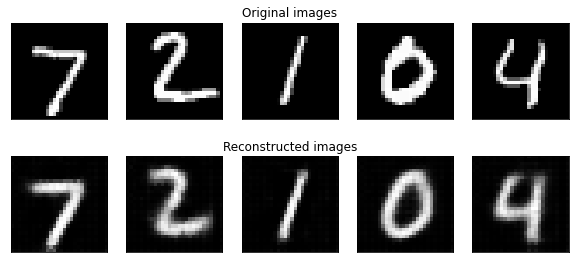

	 partial train loss (single batch): 8757.536133
	 partial train loss (single batch): 8634.703125
	 partial train loss (single batch): 8923.949219
	 partial train loss (single batch): 8845.564453
	 partial train loss (single batch): 9128.348633
	 partial train loss (single batch): 8632.047852
	 partial train loss (single batch): 8925.214844
	 partial train loss (single batch): 8939.875000
	 partial train loss (single batch): 8341.937500
	 partial train loss (single batch): 8870.424805
	 partial train loss (single batch): 8438.420898
	 partial train loss (single batch): 8645.179688
	 partial train loss (single batch): 8508.468750
	 partial train loss (single batch): 8860.336914
	 partial train loss (single batch): 9076.195312
	 partial train loss (single batch): 8771.208984
	 partial train loss (single batch): 8919.873047
	 partial train loss (single batch): 8642.480469
	 partial train loss (single batch): 8589.810547
	 partial train loss (single batch): 9187.234375
	 partial train loss

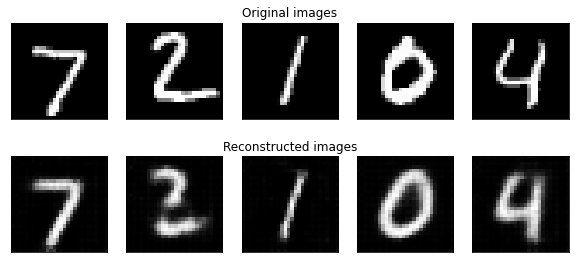

	 partial train loss (single batch): 8676.042969
	 partial train loss (single batch): 8558.577148
	 partial train loss (single batch): 8857.955078
	 partial train loss (single batch): 8812.283203
	 partial train loss (single batch): 9108.944336
	 partial train loss (single batch): 8598.151367
	 partial train loss (single batch): 8850.689453
	 partial train loss (single batch): 8980.643555
	 partial train loss (single batch): 8344.000977
	 partial train loss (single batch): 8841.564453
	 partial train loss (single batch): 8398.933594
	 partial train loss (single batch): 8671.589844
	 partial train loss (single batch): 8502.259766
	 partial train loss (single batch): 8745.080078
	 partial train loss (single batch): 9018.855469
	 partial train loss (single batch): 8749.777344
	 partial train loss (single batch): 8933.593750
	 partial train loss (single batch): 8634.872070
	 partial train loss (single batch): 8492.087891
	 partial train loss (single batch): 9085.718750
	 partial train loss

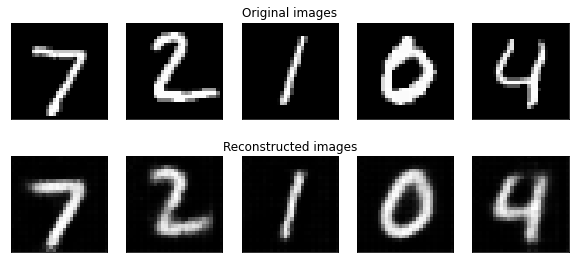

	 partial train loss (single batch): 8660.063477
	 partial train loss (single batch): 8475.451172
	 partial train loss (single batch): 8807.451172
	 partial train loss (single batch): 8778.552734
	 partial train loss (single batch): 9041.896484
	 partial train loss (single batch): 8583.964844
	 partial train loss (single batch): 8817.790039
	 partial train loss (single batch): 8893.978516
	 partial train loss (single batch): 8286.510742
	 partial train loss (single batch): 8812.488281
	 partial train loss (single batch): 8403.720703
	 partial train loss (single batch): 8549.170898
	 partial train loss (single batch): 8448.107422
	 partial train loss (single batch): 8754.244141
	 partial train loss (single batch): 9005.418945
	 partial train loss (single batch): 8621.143555
	 partial train loss (single batch): 8788.453125
	 partial train loss (single batch): 8540.214844
	 partial train loss (single batch): 8407.932617
	 partial train loss (single batch): 8957.029297
	 partial train loss

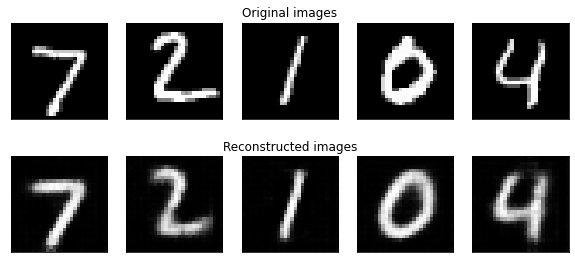

	 partial train loss (single batch): 8632.102539
	 partial train loss (single batch): 8562.193359
	 partial train loss (single batch): 8805.646484
	 partial train loss (single batch): 8723.021484
	 partial train loss (single batch): 8986.035156
	 partial train loss (single batch): 8541.000000
	 partial train loss (single batch): 8827.416016
	 partial train loss (single batch): 8908.064453
	 partial train loss (single batch): 8265.712891
	 partial train loss (single batch): 8739.864258
	 partial train loss (single batch): 8350.975586
	 partial train loss (single batch): 8579.167969
	 partial train loss (single batch): 8419.342773
	 partial train loss (single batch): 8704.271484
	 partial train loss (single batch): 8936.495117
	 partial train loss (single batch): 8595.971680
	 partial train loss (single batch): 8805.441406
	 partial train loss (single batch): 8570.947266
	 partial train loss (single batch): 8422.586914
	 partial train loss (single batch): 9028.791992
	 partial train loss

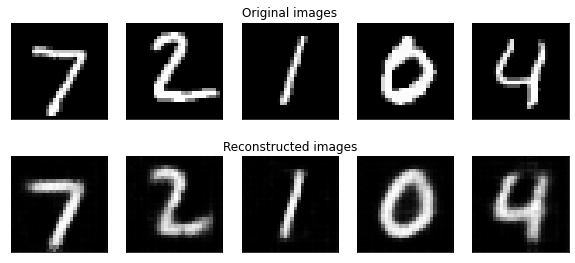

	 partial train loss (single batch): 8580.480469
	 partial train loss (single batch): 8513.642578
	 partial train loss (single batch): 8823.806641
	 partial train loss (single batch): 8699.983398
	 partial train loss (single batch): 8919.603516
	 partial train loss (single batch): 8391.311523
	 partial train loss (single batch): 8715.742188
	 partial train loss (single batch): 8838.041016
	 partial train loss (single batch): 8232.190430
	 partial train loss (single batch): 8610.208008
	 partial train loss (single batch): 8326.127930
	 partial train loss (single batch): 8479.682617
	 partial train loss (single batch): 8340.487305
	 partial train loss (single batch): 8642.759766
	 partial train loss (single batch): 8976.203125
	 partial train loss (single batch): 8554.107422
	 partial train loss (single batch): 8808.083008
	 partial train loss (single batch): 8454.535156
	 partial train loss (single batch): 8416.663086
	 partial train loss (single batch): 8952.046875
	 partial train loss

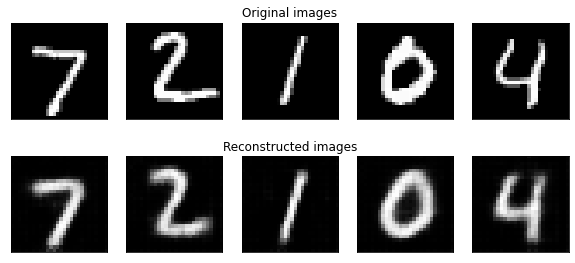

	 partial train loss (single batch): 8661.109375
	 partial train loss (single batch): 8486.939453
	 partial train loss (single batch): 8753.133789
	 partial train loss (single batch): 8682.720703
	 partial train loss (single batch): 8983.687500
	 partial train loss (single batch): 8431.087891
	 partial train loss (single batch): 8825.964844
	 partial train loss (single batch): 8799.580078
	 partial train loss (single batch): 8229.916016
	 partial train loss (single batch): 8680.576172
	 partial train loss (single batch): 8338.918945
	 partial train loss (single batch): 8486.982422
	 partial train loss (single batch): 8292.065430
	 partial train loss (single batch): 8665.376953
	 partial train loss (single batch): 8901.698242
	 partial train loss (single batch): 8539.200195
	 partial train loss (single batch): 8764.869141
	 partial train loss (single batch): 8493.494141
	 partial train loss (single batch): 8431.597656
	 partial train loss (single batch): 8882.429688
	 partial train loss

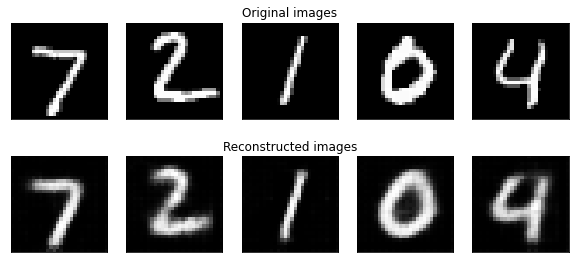

	 partial train loss (single batch): 8484.682617
	 partial train loss (single batch): 8378.098633
	 partial train loss (single batch): 8738.150391
	 partial train loss (single batch): 8656.539062
	 partial train loss (single batch): 8938.355469
	 partial train loss (single batch): 8449.299805
	 partial train loss (single batch): 8720.599609
	 partial train loss (single batch): 8782.184570
	 partial train loss (single batch): 8166.952148
	 partial train loss (single batch): 8714.522461
	 partial train loss (single batch): 8276.181641
	 partial train loss (single batch): 8479.317383
	 partial train loss (single batch): 8276.912109
	 partial train loss (single batch): 8614.373047
	 partial train loss (single batch): 8888.699219
	 partial train loss (single batch): 8584.820312
	 partial train loss (single batch): 8791.011719
	 partial train loss (single batch): 8431.207031
	 partial train loss (single batch): 8400.561523
	 partial train loss (single batch): 8909.660156
	 partial train loss

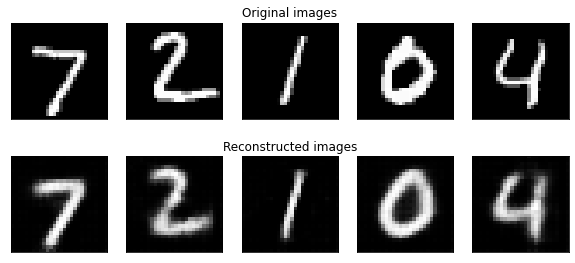

	 partial train loss (single batch): 8560.880859
	 partial train loss (single batch): 8415.619141
	 partial train loss (single batch): 8705.860352
	 partial train loss (single batch): 8575.195312
	 partial train loss (single batch): 8893.453125
	 partial train loss (single batch): 8413.843750
	 partial train loss (single batch): 8636.419922
	 partial train loss (single batch): 8732.384766
	 partial train loss (single batch): 8236.182617
	 partial train loss (single batch): 8665.521484
	 partial train loss (single batch): 8219.359375
	 partial train loss (single batch): 8500.201172
	 partial train loss (single batch): 8299.343750
	 partial train loss (single batch): 8635.600586
	 partial train loss (single batch): 8814.048828
	 partial train loss (single batch): 8542.274414
	 partial train loss (single batch): 8710.543945
	 partial train loss (single batch): 8389.453125
	 partial train loss (single batch): 8356.447266
	 partial train loss (single batch): 8809.049805
	 partial train loss

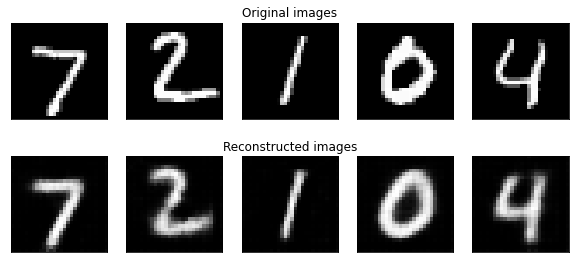

	 partial train loss (single batch): 8571.851562
	 partial train loss (single batch): 8398.349609
	 partial train loss (single batch): 8609.294922
	 partial train loss (single batch): 8663.185547
	 partial train loss (single batch): 8841.111328
	 partial train loss (single batch): 8281.667969
	 partial train loss (single batch): 8671.657227
	 partial train loss (single batch): 8764.746094
	 partial train loss (single batch): 8090.259766
	 partial train loss (single batch): 8548.429688
	 partial train loss (single batch): 8249.913086
	 partial train loss (single batch): 8418.908203
	 partial train loss (single batch): 8254.886719
	 partial train loss (single batch): 8613.667969
	 partial train loss (single batch): 8831.308594
	 partial train loss (single batch): 8478.749023
	 partial train loss (single batch): 8752.150391
	 partial train loss (single batch): 8351.968750
	 partial train loss (single batch): 8389.667969
	 partial train loss (single batch): 8758.050781
	 partial train loss

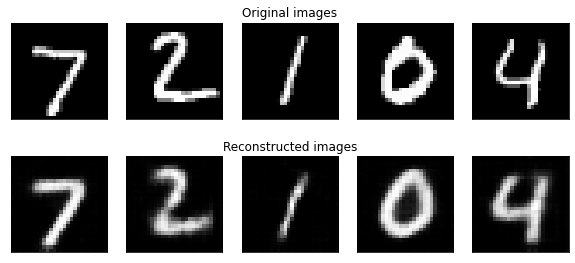

	 partial train loss (single batch): 8438.566406
	 partial train loss (single batch): 8357.070312
	 partial train loss (single batch): 8608.714844
	 partial train loss (single batch): 8559.302734
	 partial train loss (single batch): 8814.909180
	 partial train loss (single batch): 8327.230469
	 partial train loss (single batch): 8689.382812
	 partial train loss (single batch): 8666.355469
	 partial train loss (single batch): 8189.660645
	 partial train loss (single batch): 8614.814453
	 partial train loss (single batch): 8246.525391
	 partial train loss (single batch): 8365.919922
	 partial train loss (single batch): 8199.247070
	 partial train loss (single batch): 8516.099609
	 partial train loss (single batch): 8800.799805
	 partial train loss (single batch): 8450.077148
	 partial train loss (single batch): 8646.679688
	 partial train loss (single batch): 8445.271484
	 partial train loss (single batch): 8408.977539
	 partial train loss (single batch): 8827.847656
	 partial train loss

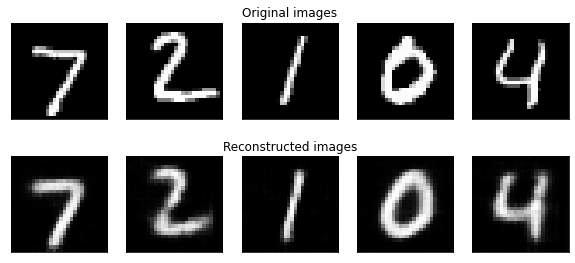

	 partial train loss (single batch): 8531.570312
	 partial train loss (single batch): 8359.563477
	 partial train loss (single batch): 8653.265625
	 partial train loss (single batch): 8522.824219
	 partial train loss (single batch): 8808.519531
	 partial train loss (single batch): 8340.675781
	 partial train loss (single batch): 8653.290039
	 partial train loss (single batch): 8671.619141
	 partial train loss (single batch): 8165.064453
	 partial train loss (single batch): 8591.738281
	 partial train loss (single batch): 8234.512695
	 partial train loss (single batch): 8402.989258
	 partial train loss (single batch): 8220.076172
	 partial train loss (single batch): 8523.068359
	 partial train loss (single batch): 8812.042969
	 partial train loss (single batch): 8423.250000
	 partial train loss (single batch): 8696.425781
	 partial train loss (single batch): 8348.928711
	 partial train loss (single batch): 8323.292969
	 partial train loss (single batch): 8778.834961
	 partial train loss

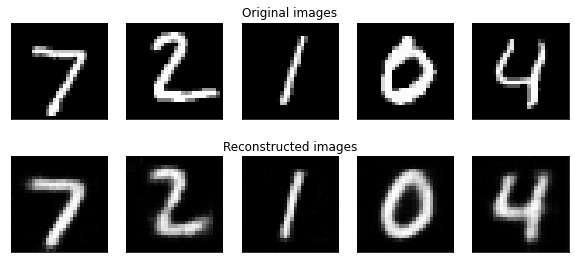

	 partial train loss (single batch): 8484.638672
	 partial train loss (single batch): 8366.273438
	 partial train loss (single batch): 8639.072266
	 partial train loss (single batch): 8604.367188
	 partial train loss (single batch): 8828.076172
	 partial train loss (single batch): 8336.600586
	 partial train loss (single batch): 8656.054688
	 partial train loss (single batch): 8674.253906
	 partial train loss (single batch): 8163.762695
	 partial train loss (single batch): 8564.125000
	 partial train loss (single batch): 8220.932617
	 partial train loss (single batch): 8396.628906
	 partial train loss (single batch): 8294.285156
	 partial train loss (single batch): 8577.115234
	 partial train loss (single batch): 8760.796875
	 partial train loss (single batch): 8444.266602
	 partial train loss (single batch): 8673.181641
	 partial train loss (single batch): 8224.030273
	 partial train loss (single batch): 8298.923828
	 partial train loss (single batch): 8729.031250
	 partial train loss

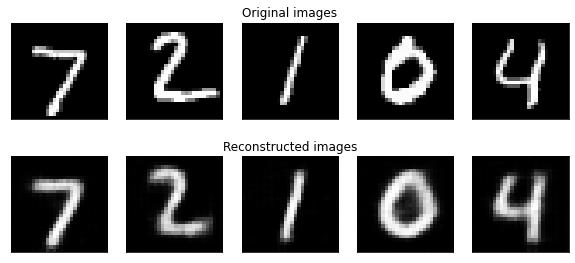

	 partial train loss (single batch): 8415.726562
	 partial train loss (single batch): 8334.010742
	 partial train loss (single batch): 8630.318359
	 partial train loss (single batch): 8513.987305
	 partial train loss (single batch): 8774.196289
	 partial train loss (single batch): 8246.970703
	 partial train loss (single batch): 8584.873047
	 partial train loss (single batch): 8699.503906
	 partial train loss (single batch): 8113.874023
	 partial train loss (single batch): 8566.144531
	 partial train loss (single batch): 8184.024414
	 partial train loss (single batch): 8354.013672
	 partial train loss (single batch): 8158.796387
	 partial train loss (single batch): 8561.934570
	 partial train loss (single batch): 8792.220703
	 partial train loss (single batch): 8398.017578
	 partial train loss (single batch): 8639.804688
	 partial train loss (single batch): 8274.715820
	 partial train loss (single batch): 8310.157227
	 partial train loss (single batch): 8780.269531
	 partial train loss

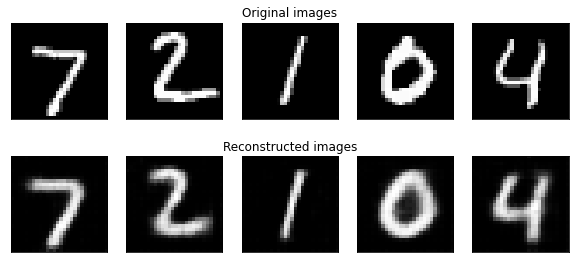

	 partial train loss (single batch): 8462.405273
	 partial train loss (single batch): 8302.129883
	 partial train loss (single batch): 8587.517578
	 partial train loss (single batch): 8494.775391
	 partial train loss (single batch): 8745.548828
	 partial train loss (single batch): 8285.412109
	 partial train loss (single batch): 8466.564453
	 partial train loss (single batch): 8634.491211
	 partial train loss (single batch): 8118.904297
	 partial train loss (single batch): 8512.896484
	 partial train loss (single batch): 8262.182617
	 partial train loss (single batch): 8239.045898
	 partial train loss (single batch): 8140.869141
	 partial train loss (single batch): 8502.438477
	 partial train loss (single batch): 8595.153320
	 partial train loss (single batch): 8447.718750
	 partial train loss (single batch): 8625.695312
	 partial train loss (single batch): 8255.522461
	 partial train loss (single batch): 8340.705078
	 partial train loss (single batch): 8716.822266
	 partial train loss

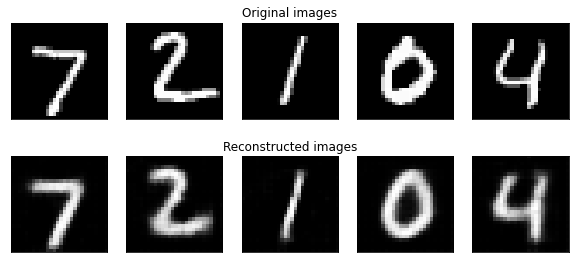

	 partial train loss (single batch): 8500.143555
	 partial train loss (single batch): 8232.839844
	 partial train loss (single batch): 8634.539062
	 partial train loss (single batch): 8538.519531
	 partial train loss (single batch): 8715.632812
	 partial train loss (single batch): 8189.887207
	 partial train loss (single batch): 8564.984375
	 partial train loss (single batch): 8616.605469
	 partial train loss (single batch): 8132.901367
	 partial train loss (single batch): 8526.435547
	 partial train loss (single batch): 8212.426758
	 partial train loss (single batch): 8223.419922
	 partial train loss (single batch): 8172.556641
	 partial train loss (single batch): 8514.824219
	 partial train loss (single batch): 8693.921875
	 partial train loss (single batch): 8421.790039
	 partial train loss (single batch): 8629.357422
	 partial train loss (single batch): 8191.531250
	 partial train loss (single batch): 8289.009766
	 partial train loss (single batch): 8772.692383
	 partial train loss

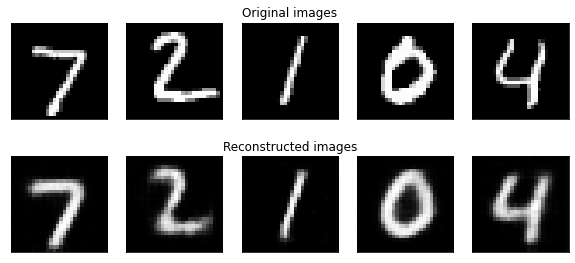

	 partial train loss (single batch): 8482.316406
	 partial train loss (single batch): 8242.720703
	 partial train loss (single batch): 8497.826172
	 partial train loss (single batch): 8512.710938
	 partial train loss (single batch): 8808.949219
	 partial train loss (single batch): 8225.869141
	 partial train loss (single batch): 8578.830078
	 partial train loss (single batch): 8583.802734
	 partial train loss (single batch): 8087.871582
	 partial train loss (single batch): 8496.279297
	 partial train loss (single batch): 8213.013672
	 partial train loss (single batch): 8313.707031
	 partial train loss (single batch): 8179.734375
	 partial train loss (single batch): 8449.972656
	 partial train loss (single batch): 8664.259766
	 partial train loss (single batch): 8428.458008
	 partial train loss (single batch): 8551.618164
	 partial train loss (single batch): 8204.091797
	 partial train loss (single batch): 8199.765625
	 partial train loss (single batch): 8715.365234
	 partial train loss

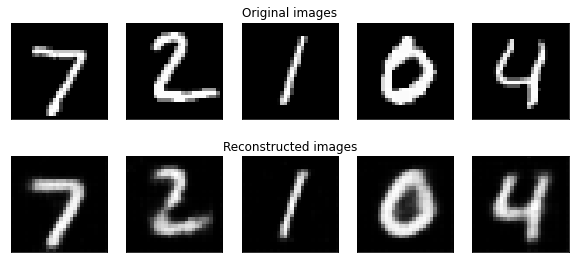

	 partial train loss (single batch): 8353.433594
	 partial train loss (single batch): 8214.850586
	 partial train loss (single batch): 8578.691406
	 partial train loss (single batch): 8498.695312
	 partial train loss (single batch): 8694.677734
	 partial train loss (single batch): 8212.708984
	 partial train loss (single batch): 8521.178711
	 partial train loss (single batch): 8617.469727
	 partial train loss (single batch): 8150.180664
	 partial train loss (single batch): 8458.436523
	 partial train loss (single batch): 8136.756836
	 partial train loss (single batch): 8234.363281
	 partial train loss (single batch): 8109.815430
	 partial train loss (single batch): 8389.012695
	 partial train loss (single batch): 8612.615234
	 partial train loss (single batch): 8422.710938
	 partial train loss (single batch): 8628.124023
	 partial train loss (single batch): 8184.047852
	 partial train loss (single batch): 8249.329102
	 partial train loss (single batch): 8633.656250
	 partial train loss

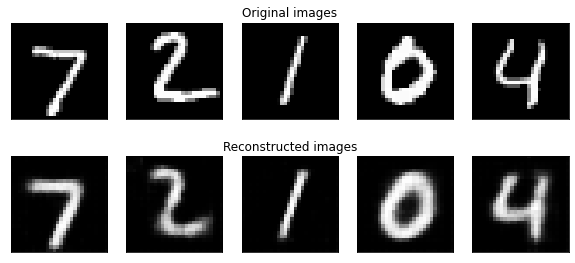

	 partial train loss (single batch): 8371.860352
	 partial train loss (single batch): 8286.100586
	 partial train loss (single batch): 8522.309570
	 partial train loss (single batch): 8474.667969
	 partial train loss (single batch): 8705.205078
	 partial train loss (single batch): 8258.437500
	 partial train loss (single batch): 8523.932617
	 partial train loss (single batch): 8578.972656
	 partial train loss (single batch): 8089.443359
	 partial train loss (single batch): 8441.025391
	 partial train loss (single batch): 8160.322266
	 partial train loss (single batch): 8259.435547
	 partial train loss (single batch): 8143.475098
	 partial train loss (single batch): 8454.092773
	 partial train loss (single batch): 8569.347656
	 partial train loss (single batch): 8285.150391
	 partial train loss (single batch): 8500.398438
	 partial train loss (single batch): 8174.668945
	 partial train loss (single batch): 8286.692383
	 partial train loss (single batch): 8723.390625
	 partial train loss

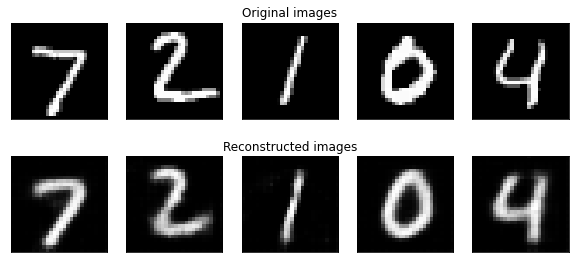

	 partial train loss (single batch): 8360.264648
	 partial train loss (single batch): 8188.299805
	 partial train loss (single batch): 8511.322266
	 partial train loss (single batch): 8431.661133
	 partial train loss (single batch): 8667.820312
	 partial train loss (single batch): 8178.883789
	 partial train loss (single batch): 8500.045898
	 partial train loss (single batch): 8662.300781
	 partial train loss (single batch): 8095.805664
	 partial train loss (single batch): 8444.562500
	 partial train loss (single batch): 8158.623047
	 partial train loss (single batch): 8230.947266
	 partial train loss (single batch): 8159.039062
	 partial train loss (single batch): 8403.501953
	 partial train loss (single batch): 8691.347656
	 partial train loss (single batch): 8366.901367
	 partial train loss (single batch): 8556.883789
	 partial train loss (single batch): 8185.160645
	 partial train loss (single batch): 8251.394531
	 partial train loss (single batch): 8569.588867
	 partial train loss

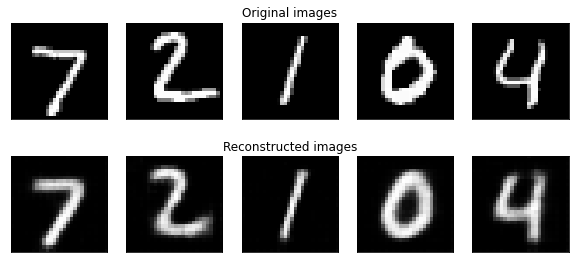

	 partial train loss (single batch): 8405.257812
	 partial train loss (single batch): 8186.375977
	 partial train loss (single batch): 8527.893555
	 partial train loss (single batch): 8464.037109
	 partial train loss (single batch): 8692.474609
	 partial train loss (single batch): 8234.914062
	 partial train loss (single batch): 8499.884766
	 partial train loss (single batch): 8588.728516
	 partial train loss (single batch): 8027.516602
	 partial train loss (single batch): 8442.199219
	 partial train loss (single batch): 8168.083984
	 partial train loss (single batch): 8221.257812
	 partial train loss (single batch): 8100.073242
	 partial train loss (single batch): 8447.164062
	 partial train loss (single batch): 8595.057617
	 partial train loss (single batch): 8371.902344
	 partial train loss (single batch): 8553.533203
	 partial train loss (single batch): 8111.802734
	 partial train loss (single batch): 8280.029297
	 partial train loss (single batch): 8558.698242
	 partial train loss

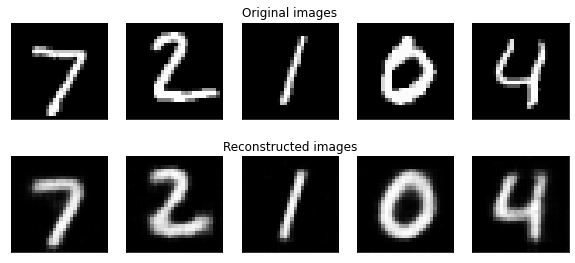

	 partial train loss (single batch): 8331.965820
	 partial train loss (single batch): 8171.616211
	 partial train loss (single batch): 8528.030273
	 partial train loss (single batch): 8431.128906
	 partial train loss (single batch): 8672.613281
	 partial train loss (single batch): 8193.019531
	 partial train loss (single batch): 8403.146484
	 partial train loss (single batch): 8494.437500
	 partial train loss (single batch): 8066.840332
	 partial train loss (single batch): 8404.050781
	 partial train loss (single batch): 8045.471680
	 partial train loss (single batch): 8153.263672
	 partial train loss (single batch): 8076.932617
	 partial train loss (single batch): 8400.662109
	 partial train loss (single batch): 8575.220703
	 partial train loss (single batch): 8292.554688
	 partial train loss (single batch): 8498.734375
	 partial train loss (single batch): 8113.858887
	 partial train loss (single batch): 8249.918945
	 partial train loss (single batch): 8634.167969
	 partial train loss

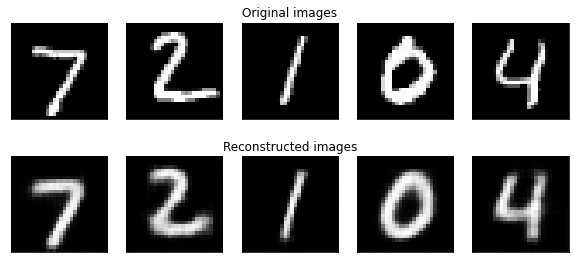

	 partial train loss (single batch): 8293.734375
	 partial train loss (single batch): 8106.543457
	 partial train loss (single batch): 8502.902344
	 partial train loss (single batch): 8405.910156
	 partial train loss (single batch): 8634.877930
	 partial train loss (single batch): 8172.558105
	 partial train loss (single batch): 8457.351562
	 partial train loss (single batch): 8579.849609
	 partial train loss (single batch): 8018.733398
	 partial train loss (single batch): 8419.870117
	 partial train loss (single batch): 8073.741211
	 partial train loss (single batch): 8152.841309
	 partial train loss (single batch): 8105.830078
	 partial train loss (single batch): 8428.449219
	 partial train loss (single batch): 8622.019531
	 partial train loss (single batch): 8364.575195
	 partial train loss (single batch): 8548.281250
	 partial train loss (single batch): 8127.009277
	 partial train loss (single batch): 8264.785156
	 partial train loss (single batch): 8579.058594
	 partial train loss

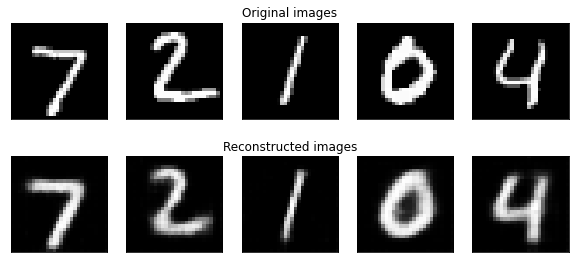

	 partial train loss (single batch): 8360.517578
	 partial train loss (single batch): 8200.212891
	 partial train loss (single batch): 8495.663086
	 partial train loss (single batch): 8442.320312
	 partial train loss (single batch): 8670.753906
	 partial train loss (single batch): 8093.625000
	 partial train loss (single batch): 8477.911133
	 partial train loss (single batch): 8543.130859
	 partial train loss (single batch): 7957.490723
	 partial train loss (single batch): 8350.344727
	 partial train loss (single batch): 8053.048828
	 partial train loss (single batch): 8191.709961
	 partial train loss (single batch): 8118.127441
	 partial train loss (single batch): 8384.884766
	 partial train loss (single batch): 8575.822266
	 partial train loss (single batch): 8318.552734
	 partial train loss (single batch): 8523.050781
	 partial train loss (single batch): 8128.470703
	 partial train loss (single batch): 8252.066406
	 partial train loss (single batch): 8658.137695
	 partial train loss

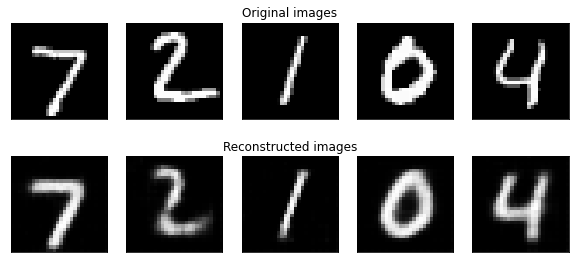

	 partial train loss (single batch): 8342.106445
	 partial train loss (single batch): 8098.600586
	 partial train loss (single batch): 8459.232422
	 partial train loss (single batch): 8460.406250
	 partial train loss (single batch): 8600.375000
	 partial train loss (single batch): 8101.430664
	 partial train loss (single batch): 8442.694336
	 partial train loss (single batch): 8471.181641
	 partial train loss (single batch): 7945.513184
	 partial train loss (single batch): 8376.894531
	 partial train loss (single batch): 8058.208984
	 partial train loss (single batch): 8106.703125
	 partial train loss (single batch): 7995.801758
	 partial train loss (single batch): 8401.011719
	 partial train loss (single batch): 8567.359375
	 partial train loss (single batch): 8329.308594
	 partial train loss (single batch): 8514.139648
	 partial train loss (single batch): 8106.577637
	 partial train loss (single batch): 8157.657715
	 partial train loss (single batch): 8543.068359
	 partial train loss

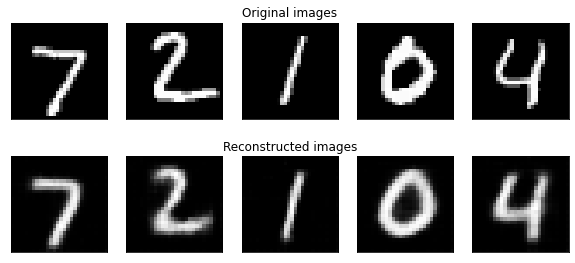

	 partial train loss (single batch): 8337.498047
	 partial train loss (single batch): 8157.995605
	 partial train loss (single batch): 8508.882812
	 partial train loss (single batch): 8454.056641
	 partial train loss (single batch): 8522.664062
	 partial train loss (single batch): 8147.986328
	 partial train loss (single batch): 8438.876953
	 partial train loss (single batch): 8535.721680
	 partial train loss (single batch): 8035.021973
	 partial train loss (single batch): 8379.071289
	 partial train loss (single batch): 8092.102539
	 partial train loss (single batch): 8188.558594
	 partial train loss (single batch): 7999.345703
	 partial train loss (single batch): 8361.916992
	 partial train loss (single batch): 8549.702148
	 partial train loss (single batch): 8346.375977
	 partial train loss (single batch): 8539.870117
	 partial train loss (single batch): 8068.914551
	 partial train loss (single batch): 8264.705078
	 partial train loss (single batch): 8573.468750
	 partial train loss

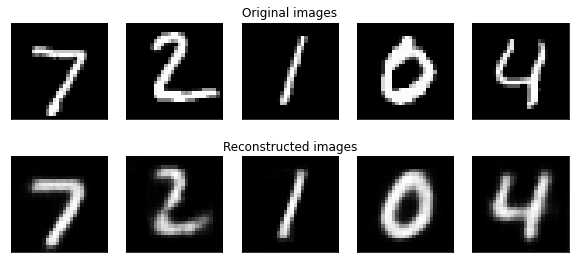

	 partial train loss (single batch): 8334.594727
	 partial train loss (single batch): 8109.470703
	 partial train loss (single batch): 8496.366211
	 partial train loss (single batch): 8309.566406
	 partial train loss (single batch): 8622.495117
	 partial train loss (single batch): 8149.993164
	 partial train loss (single batch): 8387.912109
	 partial train loss (single batch): 8460.234375
	 partial train loss (single batch): 8066.643066
	 partial train loss (single batch): 8297.149414
	 partial train loss (single batch): 8092.568359
	 partial train loss (single batch): 8061.219238
	 partial train loss (single batch): 8033.916992
	 partial train loss (single batch): 8396.714844
	 partial train loss (single batch): 8499.390625
	 partial train loss (single batch): 8295.142578
	 partial train loss (single batch): 8441.712891
	 partial train loss (single batch): 8058.431641
	 partial train loss (single batch): 8233.638672
	 partial train loss (single batch): 8590.560547
	 partial train loss

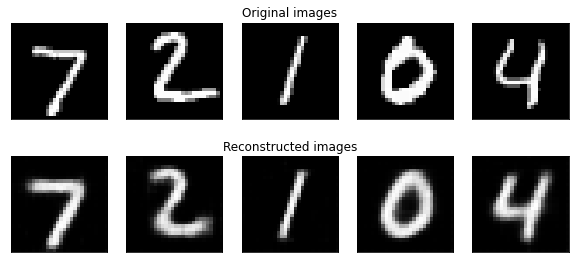

	 partial train loss (single batch): 8339.142578
	 partial train loss (single batch): 8156.961426
	 partial train loss (single batch): 8436.179688
	 partial train loss (single batch): 8374.796875
	 partial train loss (single batch): 8617.998047
	 partial train loss (single batch): 8119.426758
	 partial train loss (single batch): 8432.359375
	 partial train loss (single batch): 8494.061523
	 partial train loss (single batch): 7998.218750
	 partial train loss (single batch): 8345.691406
	 partial train loss (single batch): 8059.057129
	 partial train loss (single batch): 8070.582520
	 partial train loss (single batch): 7961.168457
	 partial train loss (single batch): 8351.545898
	 partial train loss (single batch): 8457.513672
	 partial train loss (single batch): 8204.436523
	 partial train loss (single batch): 8456.583984
	 partial train loss (single batch): 8053.976562
	 partial train loss (single batch): 8236.041016
	 partial train loss (single batch): 8557.661133
	 partial train loss

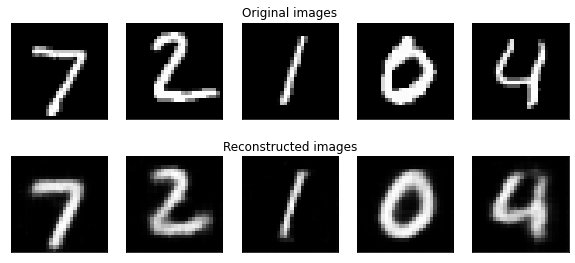

	 partial train loss (single batch): 8328.235352
	 partial train loss (single batch): 8160.964844
	 partial train loss (single batch): 8492.324219
	 partial train loss (single batch): 8340.906250
	 partial train loss (single batch): 8548.349609
	 partial train loss (single batch): 8137.970703
	 partial train loss (single batch): 8420.622070
	 partial train loss (single batch): 8461.994141
	 partial train loss (single batch): 7962.089844
	 partial train loss (single batch): 8359.173828
	 partial train loss (single batch): 8110.004395
	 partial train loss (single batch): 8085.386230
	 partial train loss (single batch): 8005.695312
	 partial train loss (single batch): 8281.251953
	 partial train loss (single batch): 8503.773438
	 partial train loss (single batch): 8322.650391
	 partial train loss (single batch): 8486.134766
	 partial train loss (single batch): 8124.510742
	 partial train loss (single batch): 8245.443359
	 partial train loss (single batch): 8533.240234
	 partial train loss

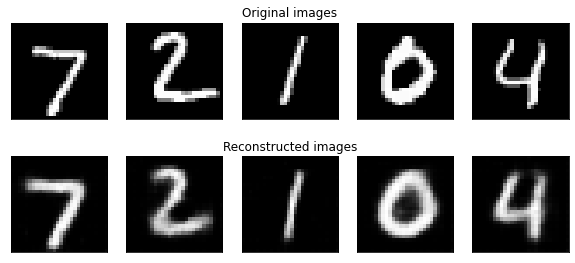

	 partial train loss (single batch): 8373.250000
	 partial train loss (single batch): 8084.601562
	 partial train loss (single batch): 8503.375000
	 partial train loss (single batch): 8385.769531
	 partial train loss (single batch): 8571.275391
	 partial train loss (single batch): 8117.209961
	 partial train loss (single batch): 8397.796875
	 partial train loss (single batch): 8494.994141
	 partial train loss (single batch): 7917.831055
	 partial train loss (single batch): 8293.826172
	 partial train loss (single batch): 8020.677734
	 partial train loss (single batch): 8061.027832
	 partial train loss (single batch): 7984.376465
	 partial train loss (single batch): 8346.195312
	 partial train loss (single batch): 8474.200195
	 partial train loss (single batch): 8285.675781
	 partial train loss (single batch): 8439.062500
	 partial train loss (single batch): 8135.097656
	 partial train loss (single batch): 8261.193359
	 partial train loss (single batch): 8474.988281
	 partial train loss

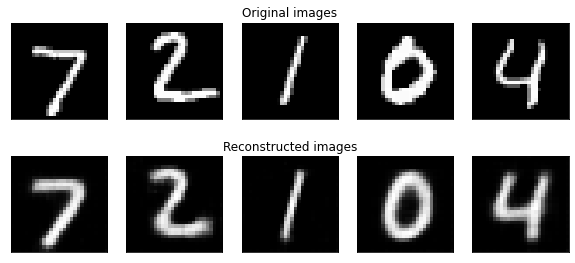

	 partial train loss (single batch): 8282.085938
	 partial train loss (single batch): 8152.803711
	 partial train loss (single batch): 8424.144531
	 partial train loss (single batch): 8362.710938
	 partial train loss (single batch): 8545.947266
	 partial train loss (single batch): 8071.735352
	 partial train loss (single batch): 8380.841797
	 partial train loss (single batch): 8439.072266
	 partial train loss (single batch): 7916.570801
	 partial train loss (single batch): 8274.578125
	 partial train loss (single batch): 8090.549805
	 partial train loss (single batch): 8041.550293
	 partial train loss (single batch): 8071.439453
	 partial train loss (single batch): 8255.933594
	 partial train loss (single batch): 8447.421875
	 partial train loss (single batch): 8264.212891
	 partial train loss (single batch): 8484.894531
	 partial train loss (single batch): 8072.367676
	 partial train loss (single batch): 8168.469727
	 partial train loss (single batch): 8526.184570
	 partial train loss

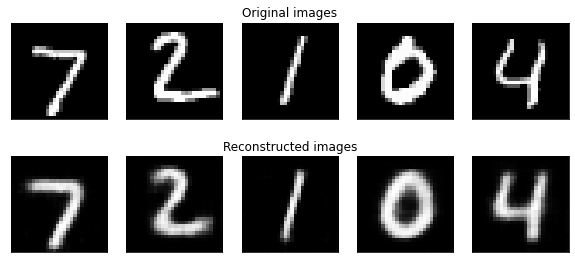

	 partial train loss (single batch): 8261.843750
	 partial train loss (single batch): 8127.190918
	 partial train loss (single batch): 8387.132812
	 partial train loss (single batch): 8368.005859
	 partial train loss (single batch): 8581.082031
	 partial train loss (single batch): 8073.183594
	 partial train loss (single batch): 8294.517578
	 partial train loss (single batch): 8479.875977
	 partial train loss (single batch): 7906.962891
	 partial train loss (single batch): 8300.574219
	 partial train loss (single batch): 7986.892578
	 partial train loss (single batch): 8104.473633
	 partial train loss (single batch): 7970.967285
	 partial train loss (single batch): 8225.697266
	 partial train loss (single batch): 8462.226562
	 partial train loss (single batch): 8257.918945
	 partial train loss (single batch): 8402.337891
	 partial train loss (single batch): 8073.049805
	 partial train loss (single batch): 8179.055664
	 partial train loss (single batch): 8500.169922
	 partial train loss

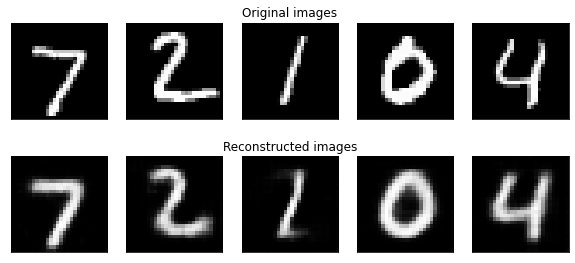

	 partial train loss (single batch): 8282.511719
	 partial train loss (single batch): 8100.127930
	 partial train loss (single batch): 8475.787109
	 partial train loss (single batch): 8267.760742
	 partial train loss (single batch): 8498.666016
	 partial train loss (single batch): 8074.162598
	 partial train loss (single batch): 8369.970703
	 partial train loss (single batch): 8460.640625
	 partial train loss (single batch): 7961.496582
	 partial train loss (single batch): 8295.250977
	 partial train loss (single batch): 8068.311523
	 partial train loss (single batch): 8003.481445
	 partial train loss (single batch): 7978.179688
	 partial train loss (single batch): 8291.964844
	 partial train loss (single batch): 8552.375000
	 partial train loss (single batch): 8286.087891
	 partial train loss (single batch): 8452.749023
	 partial train loss (single batch): 8072.192871
	 partial train loss (single batch): 8286.263672
	 partial train loss (single batch): 8511.831055
	 partial train loss

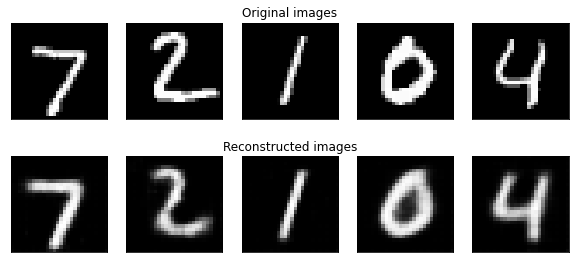

	 partial train loss (single batch): 8217.814453
	 partial train loss (single batch): 8106.123535
	 partial train loss (single batch): 8477.220703
	 partial train loss (single batch): 8430.367188
	 partial train loss (single batch): 8526.318359
	 partial train loss (single batch): 8098.680664
	 partial train loss (single batch): 8319.931641
	 partial train loss (single batch): 8445.279297
	 partial train loss (single batch): 7939.835938
	 partial train loss (single batch): 8322.576172
	 partial train loss (single batch): 8036.373047
	 partial train loss (single batch): 8028.043457
	 partial train loss (single batch): 7904.593262
	 partial train loss (single batch): 8341.111328
	 partial train loss (single batch): 8530.083008
	 partial train loss (single batch): 8239.741211
	 partial train loss (single batch): 8431.477539
	 partial train loss (single batch): 8022.945312
	 partial train loss (single batch): 8154.596680
	 partial train loss (single batch): 8370.639648
	 partial train loss

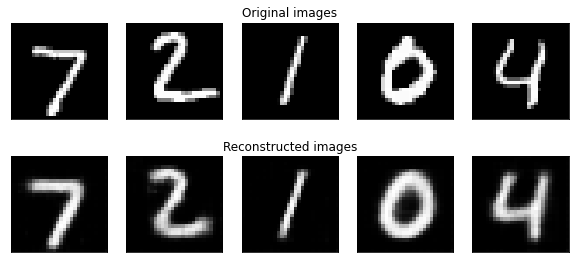

	 partial train loss (single batch): 8265.085938
	 partial train loss (single batch): 8070.453613
	 partial train loss (single batch): 8444.455078
	 partial train loss (single batch): 8351.400391
	 partial train loss (single batch): 8558.033203
	 partial train loss (single batch): 8115.437988
	 partial train loss (single batch): 8312.102539
	 partial train loss (single batch): 8438.527344
	 partial train loss (single batch): 7934.466797
	 partial train loss (single batch): 8268.746094
	 partial train loss (single batch): 8059.249512
	 partial train loss (single batch): 8002.770508
	 partial train loss (single batch): 8002.831055
	 partial train loss (single batch): 8255.342773
	 partial train loss (single batch): 8497.630859
	 partial train loss (single batch): 8239.105469
	 partial train loss (single batch): 8378.171875
	 partial train loss (single batch): 7990.800781
	 partial train loss (single batch): 8145.398926
	 partial train loss (single batch): 8431.880859
	 partial train loss

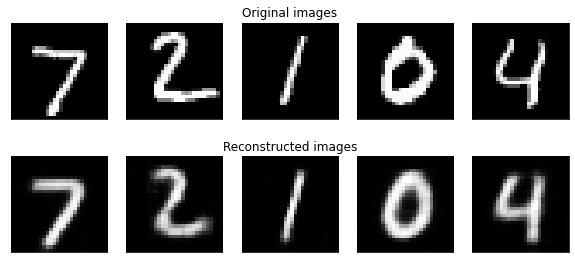

	 partial train loss (single batch): 8198.224609
	 partial train loss (single batch): 8007.952148
	 partial train loss (single batch): 8449.305664
	 partial train loss (single batch): 8300.798828
	 partial train loss (single batch): 8536.589844
	 partial train loss (single batch): 8038.298828
	 partial train loss (single batch): 8360.291016
	 partial train loss (single batch): 8464.794922
	 partial train loss (single batch): 7902.297852
	 partial train loss (single batch): 8243.951172
	 partial train loss (single batch): 8016.425293
	 partial train loss (single batch): 8011.391602
	 partial train loss (single batch): 7990.606445
	 partial train loss (single batch): 8224.351562
	 partial train loss (single batch): 8429.935547
	 partial train loss (single batch): 8280.407227
	 partial train loss (single batch): 8451.714844
	 partial train loss (single batch): 8053.760254
	 partial train loss (single batch): 8122.564453
	 partial train loss (single batch): 8541.765625
	 partial train loss

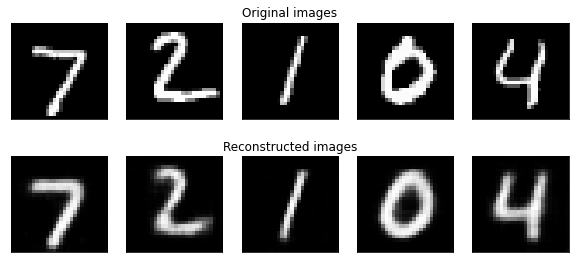

	 partial train loss (single batch): 8208.662109
	 partial train loss (single batch): 7975.429199
	 partial train loss (single batch): 8432.458984
	 partial train loss (single batch): 8290.314453
	 partial train loss (single batch): 8459.125977
	 partial train loss (single batch): 7988.327637
	 partial train loss (single batch): 8342.880859
	 partial train loss (single batch): 8436.014648
	 partial train loss (single batch): 7894.127930
	 partial train loss (single batch): 8308.751953
	 partial train loss (single batch): 8012.484375
	 partial train loss (single batch): 8049.949707
	 partial train loss (single batch): 7959.407715
	 partial train loss (single batch): 8291.306641
	 partial train loss (single batch): 8469.050781
	 partial train loss (single batch): 8211.566406
	 partial train loss (single batch): 8480.615234
	 partial train loss (single batch): 8026.236328
	 partial train loss (single batch): 8193.631836
	 partial train loss (single batch): 8466.623047
	 partial train loss

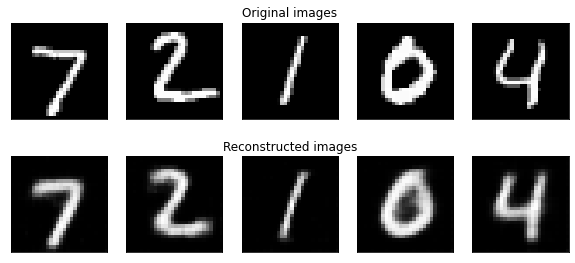

	 partial train loss (single batch): 8230.005859
	 partial train loss (single batch): 8061.745605
	 partial train loss (single batch): 8471.355469
	 partial train loss (single batch): 8359.189453
	 partial train loss (single batch): 8504.098633
	 partial train loss (single batch): 7996.233398
	 partial train loss (single batch): 8290.348633
	 partial train loss (single batch): 8435.337891
	 partial train loss (single batch): 7789.631836
	 partial train loss (single batch): 8243.755859
	 partial train loss (single batch): 8040.393555
	 partial train loss (single batch): 8025.964844
	 partial train loss (single batch): 7988.099121
	 partial train loss (single batch): 8265.666016
	 partial train loss (single batch): 8445.636719
	 partial train loss (single batch): 8297.320312
	 partial train loss (single batch): 8402.559570
	 partial train loss (single batch): 7950.671387
	 partial train loss (single batch): 8146.957031
	 partial train loss (single batch): 8485.902344
	 partial train loss

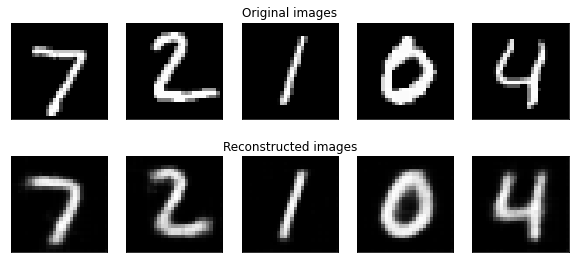

	 partial train loss (single batch): 8231.872070
	 partial train loss (single batch): 8035.101074
	 partial train loss (single batch): 8379.184570
	 partial train loss (single batch): 8255.386719
	 partial train loss (single batch): 8493.311523
	 partial train loss (single batch): 8094.562500
	 partial train loss (single batch): 8318.701172
	 partial train loss (single batch): 8396.059570
	 partial train loss (single batch): 7992.621094
	 partial train loss (single batch): 8280.877930
	 partial train loss (single batch): 8051.030273
	 partial train loss (single batch): 7975.923340
	 partial train loss (single batch): 7885.651367
	 partial train loss (single batch): 8208.873047
	 partial train loss (single batch): 8463.388672
	 partial train loss (single batch): 8290.956055
	 partial train loss (single batch): 8493.562500
	 partial train loss (single batch): 8073.085938
	 partial train loss (single batch): 8150.377441
	 partial train loss (single batch): 8425.501953
	 partial train loss

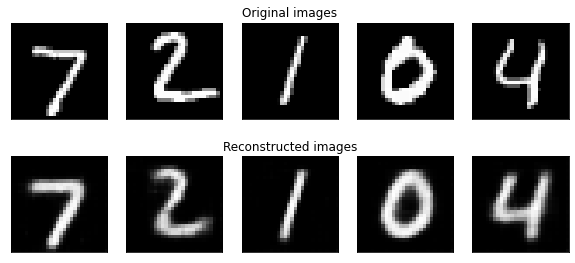

In [12]:
num_epochs = 50
for epoch in range(num_epochs):

   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

   plot_ae_outputs(vae.encoder,vae.decoder,n=5)

## 4.Generate samples

In [13]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

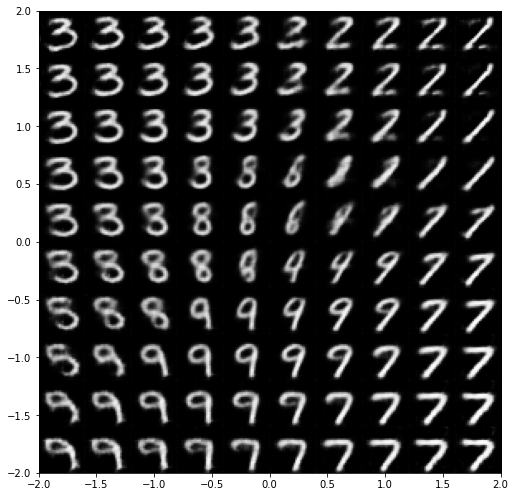

In [14]:
plot_reconstructed(vae.decoder, r0=(-2, 2), r1=(-2, 2))

## 5.Visualize latent space

In [15]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:09<00:00, 1032.80it/s]


In [16]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,0.790741,-1.252131,-0.934510,0.590801,7
1,-0.221263,1.559616,-0.911835,0.967326,2
2,0.687043,0.022008,0.864768,1.567868,1
3,-0.179204,0.046168,-0.147385,-0.978159,0
4,-0.219730,-0.865538,-0.663269,-0.445289,4
...,...,...,...,...,...
9995,0.812000,0.873848,-1.403620,0.164043,2
9996,-1.111401,0.902999,-0.265921,0.241798,3
9997,0.522504,-0.413255,-0.238132,0.054317,4
9998,0.632160,-0.127326,1.469837,-0.707672,5


In [17]:
from sklearn.manifold import TSNE
import plotly.express as px

In [22]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [19]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [21]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()